In [1]:
#Clean syn density data
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import urllib2
import numpy as np

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)
#x_bounds = (409, 3529), starts at 19
#y_bounds = (1564, 3124), starts at 1369
csv_clean = csv[np.logical_not(csv[:,3] == 0)] # get rid of unmasked values of zero
csv_clean = csv_clean[csv_clean[:,0] >= 409]
csv_clean = csv_clean[csv_clean[:,0] <= 3529]
csv_clean = csv_clean[csv_clean[:,1] >= 1564]
csv_clean = csv_clean[csv_clean[:,1] <= 3124]
csv_clean_no_ratio = csv_clean
csv_clean[:,4] = np.divide(csv_clean[:,4],csv_clean[:,3])
csv_clean[:,4] = csv_clean[:,4]*(64**3)

### 1) Histograms (Jay, Bijan)

#### 1.1 Plotting histograms of cleaned data (Bijan)

here


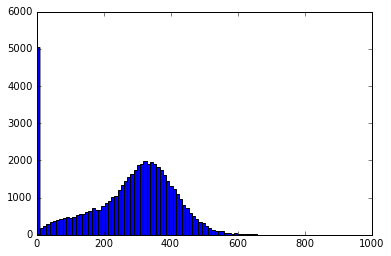

In [2]:
print 'here'
def check_condition(row):
    if row[3] == 0:
        return False
    return True

a = np.apply_along_axis(check_condition, 1, csv)
a = np.where(a == True)[0]
nonZeroMask = csv[a, :]

synDividedMask = np.divide(nonZeroMask[:,4],nonZeroMask[:,3])
synDividedMask = synDividedMask * (64**3)
accurateDataT = np.vstack((nonZeroMask[:,0],nonZeroMask[:,1],nonZeroMask[:,2],synDividedMask))
accurateData = accurateDataT.T
plt.hist(accurateData[:,3],bins=100)
plt.show()

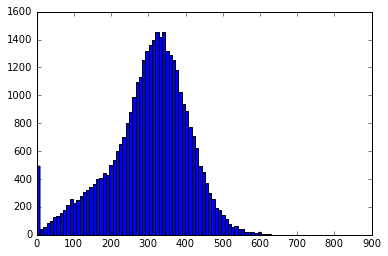

In [3]:
cleaned = accurateData[accurateData[:,0] >= 409]
cleaned = cleaned[cleaned[:,0] <= 3529]
cleaned = cleaned[cleaned[:,1] >= 1564]
cleaned = cleaned[cleaned[:,1] <= 3124]

plt.hist(cleaned[:,3], bins=100)
plt.show()

  ### Woah extra stuf

In [1]:
print 'hello world'

hello world


This looks like there is an optimal density for synapse/unmasked values at 340 or so.

#### 1.2) What is the average synapse density per voxel? How does it compare to average and min/max synapse density per bin? (Jay)
Note the 2 large spikes in the histogram.

avg density per voxel:  0.0012107238853
average per bin:  0.00115002980202 , std dev:  0.000406563246763
max/min bin density:  0.00338020281217 ,  0.0
41.4424739456


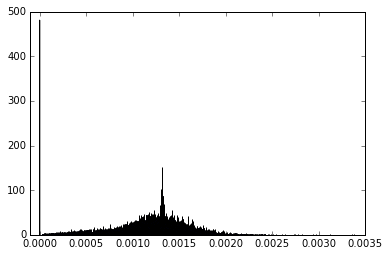

In [4]:
# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]

total_unmasked = np.sum(data_thresholded[:, 3])
total_syn = np.sum(data_thresholded[:, 4])
print "avg density per voxel: ", total_syn/total_unmasked
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)
print "average per bin: ", np.average(a), ", std dev: ", np.std(a)
print "max/min bin density: ", np.max(a), ", ", np.min(a)
print np.sum(a)
hist_n, bins, _ = plt.hist(a, 5000)
plt.xlim(-.0001, .0035)
plt.show()

#### 1.3) What fraction of the samples have 0 density? How much data was thrown out due to unmasked being 0? (Jay)

In [5]:
print "fraction: ", hist_n[0]/len(a)

ux = np.unique(data_thresholded[:, 0]).shape[0]
uy = np.unique(data_thresholded[:, 1]).shape[0]
uz = np.unique(data_thresholded[:, 2]).shape[0]
exp = ux*uy*uz
actual = data_thresholded.shape[0]
print "actual: %d, expected: %d, difference: %d" % (actual, exp, exp-actual)

fraction:  0.0133477633478
actual: 36036, expected: 36531, difference: 495


### 2) Is joint distribution uniform? (Jay)

In [7]:
# chi squared test on all bins
import scipy.stats as stats
def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
# divide synapses/unmasked by std_dev
# syn_normalized = np.apply_along_axis(normalize_syn, 1, syn_unmasked, 
#                                     np.mean(syn_unmasked[:,-1]), np.std(syn_unmasked[:,-1]))
syn_normalized = syn_unmasked
sum_syn_norm = np.sum(syn_normalized[:, 3])
avg_syn_norm = (sum_syn_norm/n)*np.ones((n))
syn_norm_1col = syn_normalized[:, -1]
print avg_syn_norm
print syn_norm_1col
print stats.chisquare(syn_norm_1col, avg_syn_norm)

[ 301.473  301.473  301.473 ...,  301.473  301.473  301.473]
[ 400.358  420.178  425.628 ...,  242.403  157.405  246.08 ]
Power_divergenceResult(statistic=1357761.9606434423, pvalue=0.0)


### 3) Are the marginal distributions uniform? (Jay)

In [8]:
def marginalize_along_axis(axis):
    unique = np.unique(syn_normalized[:, axis])
    idx_dict = dict(zip(unique, range(len(unique))))
    syn_per_unique = np.zeros(len(unique))
    for row in syn_normalized[:,]:
        syn_per_unique[idx_dict[row[axis]]] += row[-1]
    return syn_per_unique

for axis in range(3):
    marginalized_data = marginalize_along_axis(axis)
    n = len(np.unique(syn_normalized[:, axis]))
    print "n=", n
    avg = sum_syn_norm/n
    avg_vec = np.ones((n))*avg
    print "axis = ", axis, "chisquare test: ", stats.chisquare(marginalized_data, avg_vec)

n= 81
axis =  0 chisquare test:  Power_divergenceResult(statistic=19641.411877476548, pvalue=0.0)
n= 41
axis =  1 chisquare test:  Power_divergenceResult(statistic=340888.29730870121, pvalue=0.0)
n= 11
axis =  2 chisquare test:  Power_divergenceResult(statistic=89131.566812296718, pvalue=0.0)


### 4) Data Visualization (Emily)

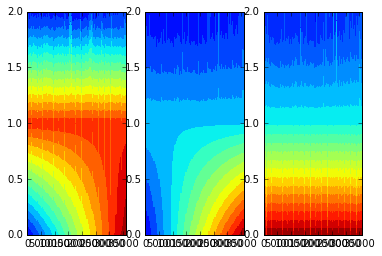

In [9]:


fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
ax1.contourf(csv_clean[:,(0,1,4)].T,20)
ax2.contourf(csv_clean[:,(0,2,4)].T,20)
ax3.contourf(csv_clean[:,(1,2,4)].T,20)
plt.show()

### 5) 2D Kernel Density Estimation (Emily)

A large portion of the directional density seems to be along the x-axis.

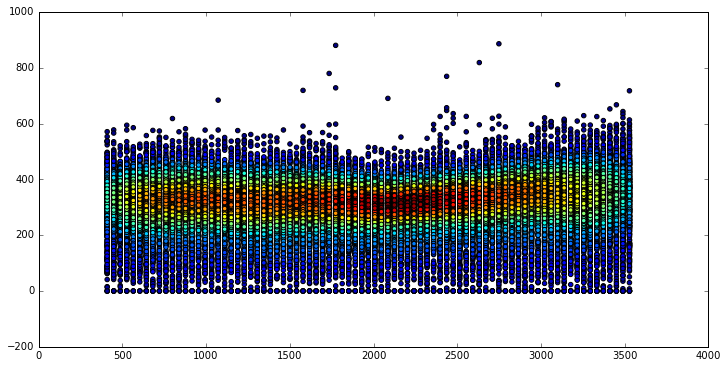

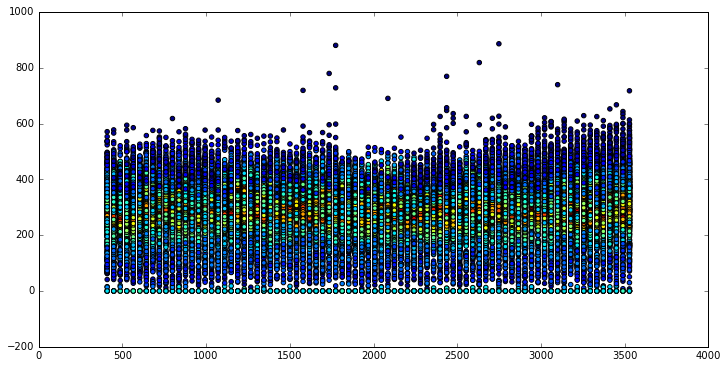

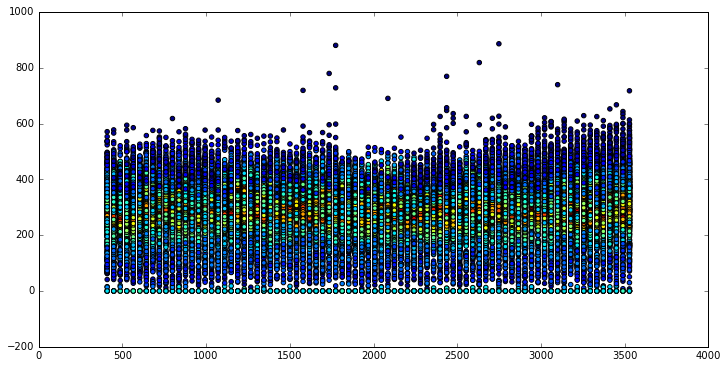

In [10]:
import scipy.stats as stats

#KDE x,syn
data_clean = csv_clean[:,(0,4)].T
# randomly sample
samples = 20000
perm = np.random.permutation(xrange(1, len(data_clean[:])))
rs_data_clean = data_clean[perm[:20000]]

kde = stats.gaussian_kde(data_clean) # KDE for x,synapses
density = kde(data_clean)

fig1 = plt.figure(figsize=(12,6))
x, syn = data_clean
plt.scatter(x, syn, c=density)
plt.show()

#KDE y,syn
fig2 = plt.figure(figsize=(12,6))
data_clean = csv_clean[:,(1,4)].T
# randomly sample
samples = 20000
perm = np.random.permutation(xrange(1, len(data_clean[:])))
rs_data_clean = data_clean[perm[:20000]]

kde = stats.gaussian_kde(data_clean) # KDE for y,synapses
density = kde(data_clean)

y, syn = data_clean
plt.scatter(x, syn, c=density)
plt.show()

#KDE z,syn
fig3 = plt.figure(figsize=(12,6))
data_clean = csv_clean[:,(1,4)].T
# randomly sample
samples = 20000
perm = np.random.permutation(xrange(1, len(data_clean[:])))
rs_data_clean = data_clean[perm[:20000]]

kde = stats.gaussian_kde(data_clean) # KDE for z,synapses
density = kde(data_clean)

z, syn = data_clean
plt.scatter(x, syn, c=density)
plt.show()


### 6) GMM Clustering: Is our density data uniformly distributed? What is the optimal number of clusters for our data? (Emily, Jay, Bijan)
No, the optimal number of clusters looks to be 4 from the BIC curve.

[ 2100389.837  2094880.867  2089231.581  2082509.026  2082863.312
  2080530.204  2079116.938  2074708.757  2071551.705  2070263.031
  2067869.343  2067598.045  2068226.908  2067235.633]


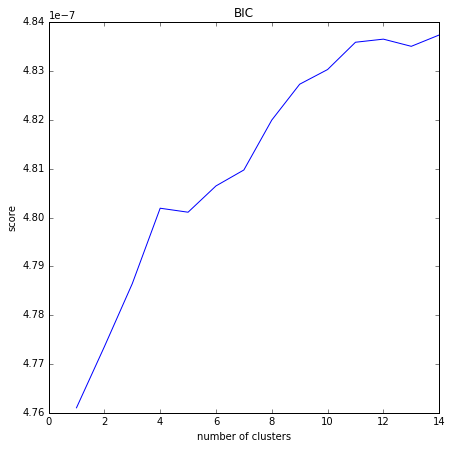

In [11]:
import sklearn.mixture as mixture

max_clusters = 15
bic = np.array([])
i = np.array(range(1, max_clusters))
for idx in range(1, max_clusters):
    #print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag', random_state=1)
    gmm.fit(csv_clean[:,(0,1,2,4)])
    bic = np.append(bic, gmm.bic(csv_clean[:,(0,1,2,4)]))
    #print 'Statistics:' + '\nWeights: ' + str(gmm.weights_) + '\nMeans: ' + str(gmm.means_) + '\nCovariances: ' + str(gmm.covars_)
print bic
plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()

### 7) Compute mean, covariance on each cluster seperately (Jay)
Observations:
* 2 larger clusters of approximately equal size, and 2 smaller clusters of approximately equal size
* determinant of covariance matrix correlates with number of samples in cluster
* note on-diagonal covariances are generally higher
* fairly large deviation between the average synapses across clusters

In [12]:
# to keep model as simple as possible, let's assume 4 clusters

n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
clusters = [[] for i in xrange(n_clusters)]
predicted = gmm.fit_predict(syn_normalized)
for label, row in zip(predicted, syn_normalized[:,]):
    clusters[label].append(row)

for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print

# of samples in cluster 1: 10413
centroid:  [ 2847.985  2298.506   612.963   315.191]
cluster covariance: 
[[ 168166.06     -365.784   -1288.3      6747.015]
 [   -365.784   98859.339   -1944.851    3117.071]
 [  -1288.3     -1944.851  121449.865    -613.809]
 [   6747.015    3117.071    -613.809   10118.623]]
determinant of covariance matrix:  1.96712741238e+19

# of samples in cluster 2: 6885
centroid:  [ 1885.862  1734.592   594.458   382.929]
cluster covariance: 
[[ 766013.849   -7179.378    7680.772    2402.616]
 [  -7179.378   12768.578   -1305.694     -99.946]
 [   7680.772   -1305.694  118941.368   -1899.735]
 [   2402.616     -99.946   -1899.735    3738.72 ]]
determinant of covariance matrix:  4.27383286219e+18

# of samples in cluster 3: 11317
centroid:  [ 1214.271  2324.484   619.122   295.86 ]
cluster covariance: 
[[ 233306.223   -2110.473   -2683.86    -2622.013]
 [  -2110.473   84653.307   -1514.014    3398.717]
 [  -2683.86    -1514.014  123618.931     541.291]
 [  -2622

### 8) Are distributions within clusters uniform? (Jay)

In [13]:
# check if uniform distribution within cluster

for cluster in clusters:
    sum_syn = np.sum(cluster[:, -1])
    avg_syn_vec = (sum_syn/cluster.shape[0])*np.ones((cluster.shape[0]))
    print stats.chisquare(cluster[:, -1], avg_syn_vec)

Power_divergenceResult(statistic=334258.15382977051, pvalue=0.0)
Power_divergenceResult(statistic=67211.853007060054, pvalue=0.0)
Power_divergenceResult(statistic=316939.80828423402, pvalue=0.0)
Power_divergenceResult(statistic=377535.68656430382, pvalue=0.0)


### 9) Graph clusters in Euclidean 3D Space (Jay)

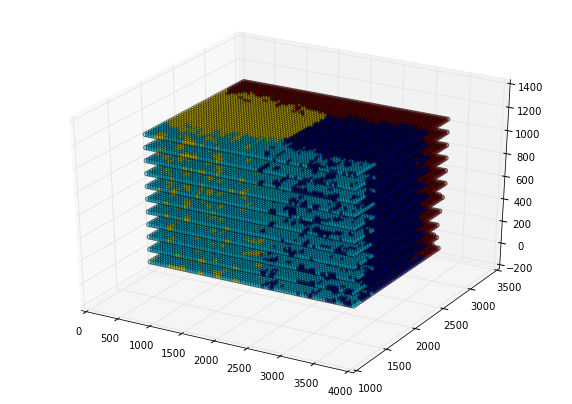

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

ax.scatter(
           syn_normalized[:, 0], syn_normalized[:, 1], syn_normalized[:, 2],  # data
           c=predicted,  # marker colour
           alpha=.5
    )

plt.show()

### 10) Check clusters in the x, y, and z (Emily, Bijan)
The optimal number of clusters looks to be 3, contradicting what we observed in our BIC curve above.
We still don't see any uniformity since the optimal number of clusters is not 1.

Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.


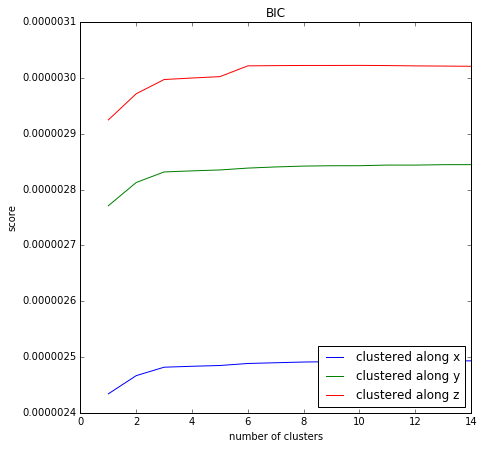

In [16]:
max_clusters = 15
csv_clean[:,4] = np.divide(csv_clean[:,4],64**3)
bicx = np.array([])
bicy = np.array([])
bicz = np.array([])
i = np.array(range(1, max_clusters))
for idx in range(1, max_clusters):
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag', random_state = 1)
    gmm.fit(csv_clean[:,(0,4)])
    bicx = np.append(bicx, gmm.bic(csv_clean[:,(0,4)]))
    
    gmm.fit(csv_clean[:,(1,4)])
    bicy = np.append(bicy, gmm.bic(csv_clean[:,(1,4)]))
    
    gmm.fit(csv_clean[:,(2,4)])
    bicz = np.append(bicz, gmm.bic(csv_clean[:,(2,4)]))
plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bicx, i, 1.0/bicy, i, 1.0/bicz)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.legend(['clustered along x','clustered along y','clustered along z'],loc='lower right')
plt.show()
csv_clean[:,4] = csv_clean[:,4] * 64**3

### 11) Check for optimal number of clusters in each z-layer (checking for uniformity across z-layers) (Emily, Bijan)
We see that in some z-layers the optimal number of clusters is 3 and for some it is 4. We don't see uniformity within z-layers.

Running GMM on layer 55.0
Running GMM on layer 166.0
Running GMM on layer 277.0
Running GMM on layer 388.0
Running GMM on layer 499.0
Running GMM on layer 610.0
Running GMM on layer 721.0
Running GMM on layer 832.0
Running GMM on layer 943.0
Running GMM on layer 1054.0
Running GMM on layer 1165.0


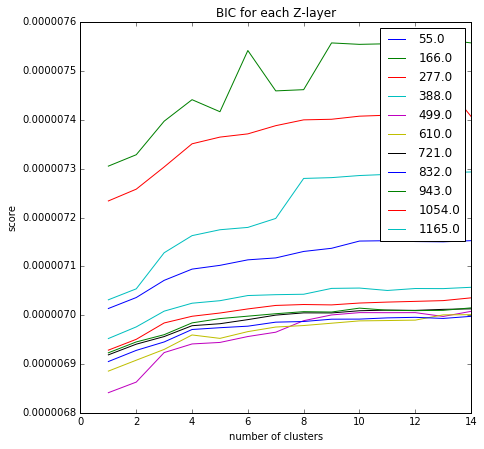

In [17]:
# Check for uniformity in clusters along z-direction
# suggested # of clusters by BIC curve says clusters fairly consistent across z at n=4 clusters
# Step size for z: 1st value 55, increments of 111
plt.figure(figsize=(7,7))
divisions = np.unique(csv_clean[:,2])

for d in divisions:
	z_layer = csv_clean[csv_clean[:,2] == d]

	#Run GMM on layer
	print 'Running GMM on layer ' + str(d)
	max_clusters = 15
	bic = np.array([])
	i = np.array(range(1, max_clusters))
	for idx in range(1, max_clusters):
	    #print "Fitting and evaluating model with " + str(idx) + " clusters."
	    gmm = mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag', random_state=1)
	    gmm.fit(z_layer[:,(0,1,4)])
	    bic = np.append(bic, gmm.bic(z_layer[:,(0,1,4)]))
	#print bic
	plt.plot(i, 1.0/bic)
	plt.hold(True)
plt.title('BIC for each Z-layer')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.legend(divisions)
plt.show()

### 12) K-Means Clustering for n=4 (as suggested by the BIC curve in item 3/5) (Emily)
For GMM clustering, the optimal number of clusters overall looked to be 4, but some of our analysis in item 4 suggests otherwise. We will investigate clustering with 4 clusters.

[[ 3059.693  2317.741   616.037]
 [ 1930.944  1906.711   605.017]
 [  870.318  2350.657   611.216]
 [ 1989.395  2759.978   630.274]]


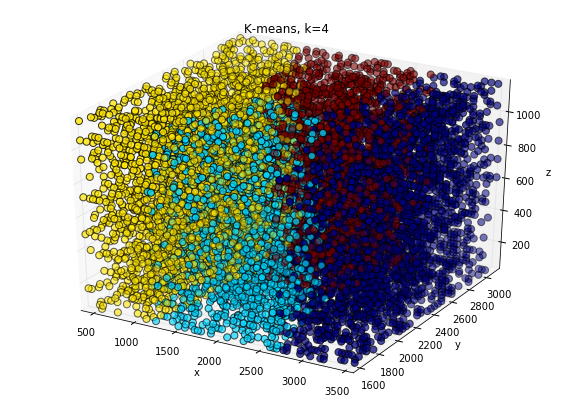

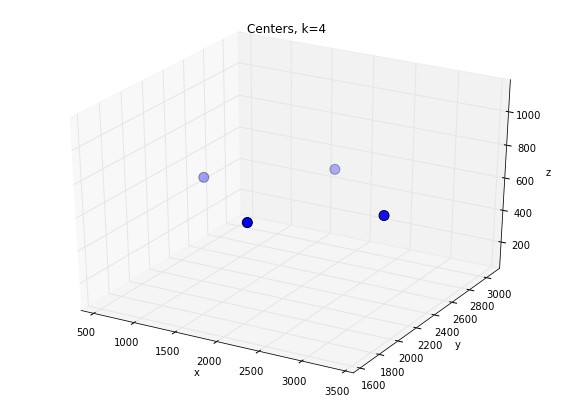

In [18]:
import sklearn.cluster as cluster
from mpl_toolkits.mplot3d import Axes3D

def graph_cluster(xyz_only, clusters, centers, k):
    # randomly sample
    samples = 10000
    perm = np.random.permutation(xrange(1, len(xyz_only[:])))
    xyz_only = xyz_only[perm[:samples]]
    clusters = clusters[perm[:samples]]

    # get range for graphing
    mins = [np.amin(xyz_only[:, i]) for i in xrange(3)]
    maxs = [np.amax(xyz_only[:, i]) for i in xrange(3)]

    # following code adopted from
    # https://www.getdatajoy.com/examples/python-plots/3d-scatter-plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')

    ax.set_title('K-means, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
               xyz_only[:, 0], xyz_only[:, 1], xyz_only[:, 2],  # data
               c=clusters,  # marker colour
               marker='o',  # marker shape
               s=50  # marker size
    )

    plt.show()
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    ax.set_title('Centers, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
           centers[:, 0], centers[:, 1], centers[:, 2],  # data
           c='blue',  # marker colour
           marker='o',  # marker shape
           s=100  # marker size
    )
    plt.show()

n_clusters = 4
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(csv_clean[:,[0,1,2]])
centers = kmeans.cluster_centers_
print centers
graph_cluster(csv_clean[:,[0,1,2]], clusters, centers, n_clusters)

### 13) K-Means Clustering for n=3 (as suggested by BIC curves in item 4/5) (Emily)
In items 4 and 5 suggests there is a good case for 3 clusters. We will investigate K-means clustering with n=3.

[[ 1968.24   2332.998   615.623]
 [  915.565  2339.026   612.45 ]
 [ 3021.863  2328.722   617.543]]


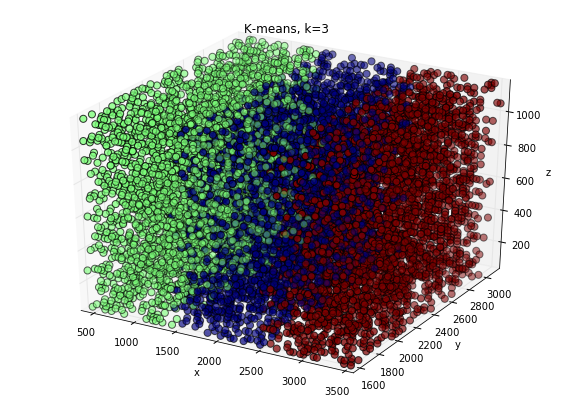

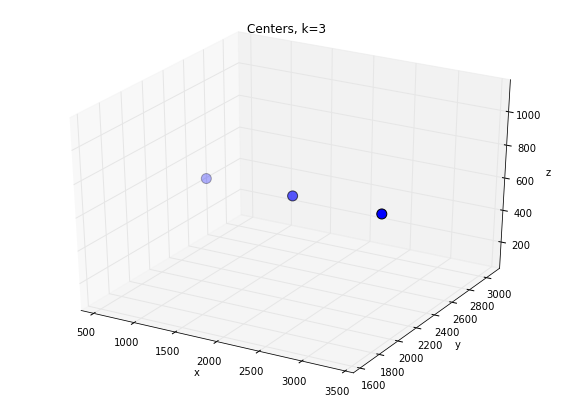

In [19]:
n_clusters = 3
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(csv_clean[:,[0,1,2]])
centers = kmeans.cluster_centers_
print centers
graph_cluster(csv_clean[:,[0,1,2]], clusters, centers, n_clusters)

### Comments on items 12 and 13:
BIC(GMM)/PCA (analysis by Jay) both predicted 4 clusters, but it seems that 3 clusters looks a lot better. Some bic curves predicted optimal number of clusters to be 3 z-layers. For what we know about anatomy of brain, zones of brain usually divided by depth, don't usually see parting division we see in n=4. Later, we will investigate why 3 clusters looks so much better and more reasonable than 4 clusters.


### 14) Direction Estimate (Bijan, Emily)
Visually, the k-means clustering shows us some interesting data. It looks like 3 clusters might be the correct number.

Let's try to find a general trends in pathing from center to center of the clusters. This might give us an estimate for direction of change in clusters

### 15) Let's look at the position of the cluster centers across z-values (Emily, Bijan)

#### 15.1) n = 3

Running GMM on layer 55.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 166.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 277.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 388.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 499.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 610.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 721.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 832.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 943.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 1054.0
Fitting and evaluating model with 3 clusters.
Running GMM on layer 1165.0
Fitting and evaluating model with 3 clusters.


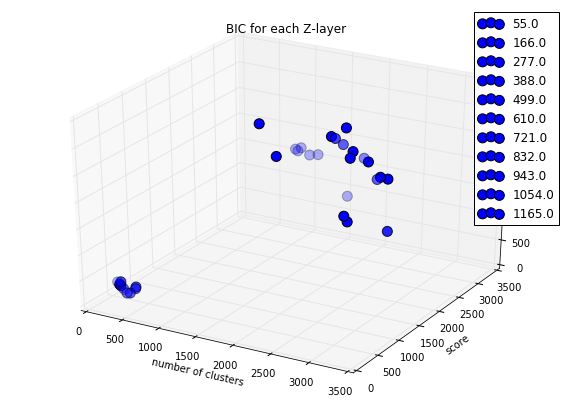

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
for d in divisions:
	z_layer = csv_clean[csv_clean[:,2] == d]

	#Run GMM on layer
	print 'Running GMM on layer ' + str(d)
	print "Fitting and evaluating model with 3 clusters."
	gmm = mixture.GMM(n_components=3,n_iter=1000,covariance_type='diag', random_state=1)
	gmm.fit(z_layer[:,(0,1,4)])
	center1 = [gmm.means_[0][0],gmm.means_[0][1],gmm.means_[0][2]]
	center2 = [gmm.means_[1][0],gmm.means_[1][1],gmm.means_[1][2]]
	center3 = [gmm.means_[2][0],gmm.means_[2][1],gmm.means_[2][2]]
	ax.scatter(center1, center2, center3, marker='o',  s=100)
	plt.hold(True)

plt.title('BIC for each Z-layer')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.legend(divisions)
plt.show()

#### 15.2) n=4 

Running GMM on layer 55.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 166.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 277.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 388.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 499.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 610.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 721.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 832.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 943.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 1054.0
Fitting and evaluating model with 4 clusters.
Running GMM on layer 1165.0
Fitting and evaluating model with 4 clusters.


//anaconda/lib/python2.7/site-packages/mpl_toolkits/mplot3d/art3d.py:728: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif zdir[0] == '-':


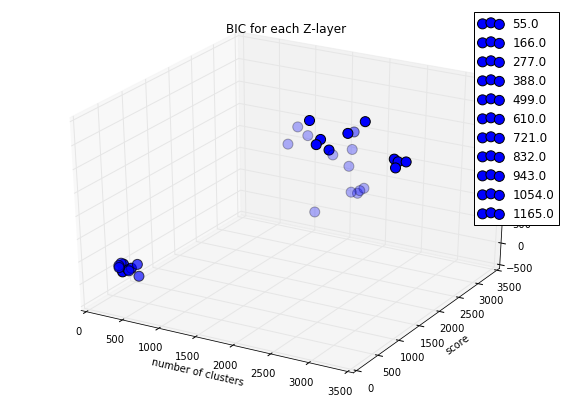

In [21]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
for d in divisions:
	z_layer = csv_clean[csv_clean[:,2] == d]

	#Run GMM on layer
	print 'Running GMM on layer ' + str(d)
	print "Fitting and evaluating model with 4 clusters."
	gmm = mixture.GMM(n_components=4,n_iter=1000,covariance_type='diag', random_state=1)
	gmm.fit(z_layer[:,(0,1,4)])
	center1 = [gmm.means_[0][0],gmm.means_[0][1],gmm.means_[0][2]]
	center2 = [gmm.means_[1][0],gmm.means_[1][1],gmm.means_[1][2]]
	center3 = [gmm.means_[2][0],gmm.means_[2][1],gmm.means_[2][2]]
	center4 = [gmm.means_[3][0],gmm.means_[3][1],gmm.means_[3][2]]
	ax.scatter(center1, center2, center3, center4, marker='o',  s=100)
	plt.hold(True)

plt.title('BIC for each Z-layer')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.legend(divisions)
plt.show()

The lower z-values behave differently from the other sections. Those are probably the z balue BIC curves that had elbows at 3. Overall, it looks like 3 clusters behaves more reasonably, but we should do further analysis.

Let's try to refine the gradient of synaptic density across axes (Jay's analysis).

### 16) Can we estimate the gradient of density? (Jay)

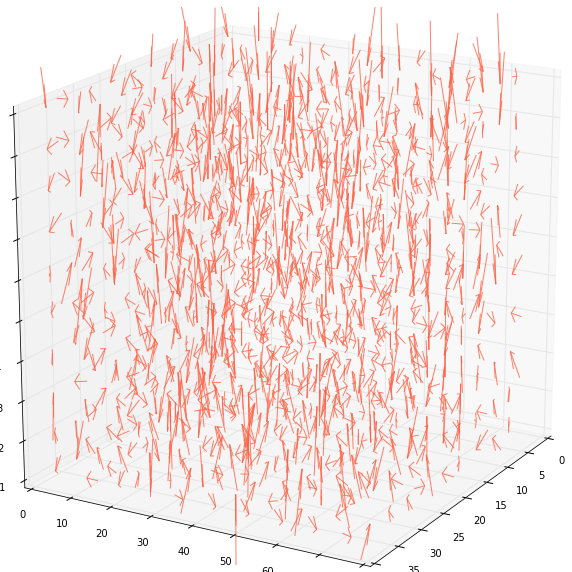

In [22]:
syn_normalized = syn_unmasked

uniques = [np.unique(syn_normalized[:, i]) for i in xrange(3)]
coord_mapping = {}
for xi, x in enumerate(uniques[0]):
    for yi, y in enumerate(uniques[1]):
        for zi, z in enumerate(uniques[2]):
            coord_mapping[(x, y, z)] = (xi, yi, zi)
gridded_data = np.empty((len(uniques[0]), len(uniques[1]), len(uniques[2])))

for row in syn_normalized[:, ]:
    coord = coord_mapping[tuple(row[:3])]
    gridded_data[coord[0], coord[1], coord[2]] = row[-1]

dx = uniques[0][1]-uniques[0][0]
dy = uniques[1][1]-uniques[1][0]
dz = uniques[2][1]-uniques[2][0]

grad = np.gradient(gridded_data, dx, dy, dz)

def get_gradient_components(x, y, z):
    u = grad[0][x, y, z]
    v = grad[1][x, y, z]
    w = grad[2][x, y, z]
    return (u, v, w)

x, y, z  = np.meshgrid(np.arange(1, 41, 4), np.arange(1, 81, 8), np.arange(1, 11))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, grad[0][1::8, 1::4, 1:], grad[1][1::8, 1::4, 1:], grad[2][1::8, 1::4, 1:], length=2, color="Tomato", alpha=.8, 
          arrow_length_ratio=.4)
ax.view_init(elev=18, azim=30) 
ax.dist = 8
plt.show()

#### 16.1) What's the average gradient? What's the standard dev of each component of the gradient? (Jay)

In [23]:
print "Avg. gradient: (%.4f, %.4f, %.4f)" % (np.average(grad[0]), np.average(grad[1]), np.average(grad[2]))
print "Std. dev per element: (%.4f, %.4f, %.4f)" % (np.std(grad[0]), np.std(grad[1]), np.std(grad[2]))

Avg. gradient: (0.0050, -0.0005, -0.0069)
Std. dev per element: (1.5135, 2.1203, 0.8300)


### 17) PCA (Jay)

[[ 0.11  -0.7    0.004  0.706]
 [-0.576 -0.13  -0.806 -0.035]
 [ 0.807  0.066 -0.584 -0.056]
 [-0.074  0.699 -0.091  0.705]]
[ 0.347  0.252  0.248  0.153]
(36036, 4)


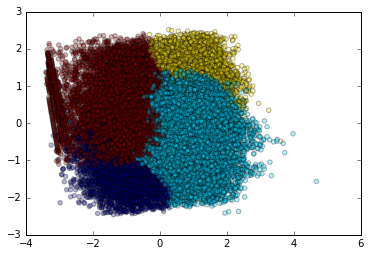

In [24]:
from sklearn.decomposition import PCA

# center each variable and give it unit variance for PCA

def center(row, means, std_devs):
    for idx, mean, std_dev in zip(range(4), means, std_devs):
        row[idx] -= mean
        row[idx] *= 1.0/std_dev
    return row

syn_centered = np.apply_along_axis(center, 1, syn_normalized,
                                   *zip(*[(np.average(syn_normalized[:, i]), 
                                   np.std(syn_normalized[:, i])) for i in range(4)]))
pca = PCA(n_components = 4)
transform = pca.fit_transform(syn_centered)
print pca.components_
print pca.explained_variance_ratio_
print transform.shape

# plot the clusters along the first 2 principal components
n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
predicted = gmm.fit_predict(syn_normalized)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.show()

Observe fairly well defined boundary between clusters. Lets plot the 2D PCA when there are 3 and 12 clusters.

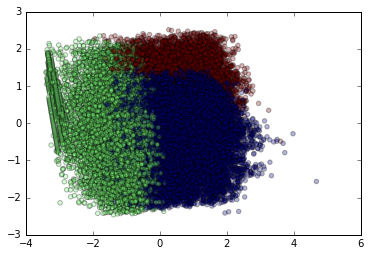

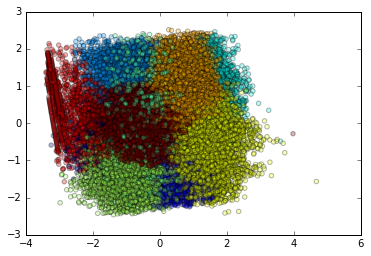

In [25]:
n_clusters = 3
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
predicted = gmm.fit_predict(syn_normalized)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.show()

n_clusters = 12
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
predicted = gmm.fit_predict(syn_normalized)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.show()

For larger clusters, boundaries remain pretty well defined, although they are not very apparent for small clusters.

### 18) Regression on (x,y,z) to predict syn/unmasked (Jay, Emily)
These regressions didn't seem to capture anything about the data.

In [26]:
# Regression (x,y,z,syn/unmasked) on cleaned data ##################################
# Load regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
k_fold = 10

print('Regression on X=(x,y,z), Y=syn/unmasked')
X = csv_clean[:, (0, 1, 2)] # x,y,z
Y = csv_clean[:, 4] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))


Regression on X=(x,y,z), Y=syn/unmasked
R^2 of Linear Regression: 0.12 (+/- 0.16)
R^2 of SVR: -1.42 (+/- 2.34)
R^2 of KNN Regression: 0.20 (+/- 0.08)
R^2 of Random Forest Regression: 0.22 (+/- 0.12)
R^2 of Polynomial Regression: 0.18 (+/- 0.17)


### 19) Marginal regressions to predict synapses/unmasked (conditioned on x, y, z d separately) (Jay, Emily)
Since the regression above didn't capture anything about the data, we wanted break it down and see if any variable was good at predicting syn/unmasked.

In [27]:
# x -> syn/unmasked
print('Regression on X=x, Y=syn/unmasked')
X = csv_clean[:,[0]] # x,y,z
Y = csv_clean[:,4] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# y -> syn/unmasked
print('Regression on X=y, Y=syn/unmasked')
X = csv_clean[:,[1]] # x,y,z
Y = csv_clean[:,4] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# z -> syn/unmasked
print('Regression on X=z, Y=syn/unmasked')
X = csv_clean[:,[2]] # x,y,z
Y = csv_clean[:,4] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

Regression on X=x, Y=syn/unmasked
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -2.51 (+/- 9.42)
R^2 of KNN Regression: -0.17 (+/- 0.36)
R^2 of Random Forest Regression: -0.10 (+/- 0.30)
R^2 of Polynomial Regression: -0.01 (+/- 0.02)
Regression on X=y, Y=syn/unmasked
R^2 of Linear Regression: 0.12 (+/- 0.15)
R^2 of SVR: -2.60 (+/- 8.69)
R^2 of KNN Regression: 0.00 (+/- 0.19)
R^2 of Random Forest Regression: 0.14 (+/- 0.15)
R^2 of Polynomial Regression: 0.14 (+/- 0.16)
Regression on X=z, Y=syn/unmasked
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -1.69 (+/- 3.83)
R^2 of KNN Regression: -0.08 (+/- 0.08)
R^2 of Random Forest Regression: 0.04 (+/- 0.05)
R^2 of Polynomial Regression: 0.01 (+/- 0.05)
